# Notebook to fix visualization errors

- [ ] check out the seeded median
- [ ] stream some data and see what it identifies as spikes using the MAD

In [5]:
import fastplotlib as fpl 
import numpy as np
import zmq
import tifffile
import scipy

In [2]:
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

In [3]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [6]:
median = np.median(butter_filter(data[:, :4000], 1_000, 30_000), axis=1)
median.shape

(384,)

In [78]:
d = butter_filter(data[:8, 2_500_000:2_500_150], 1_000, 30_000)

RFBOutputContext()

JupyterRenderCanvas(css_height='800.0px', css_width='1500.0px')
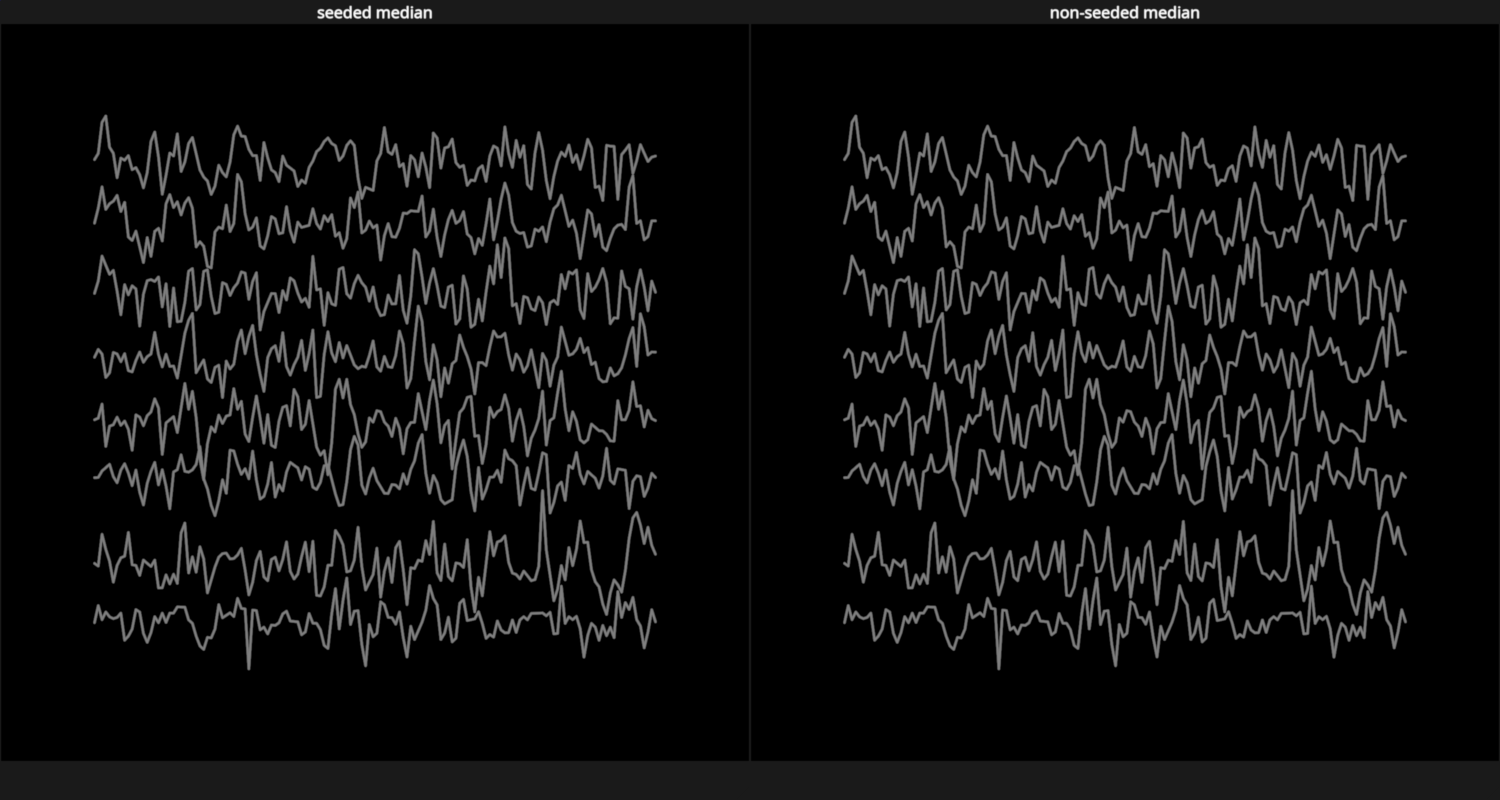

In [79]:
fig = fpl.Figure(shape=(1,2), names=["seeded median", "non-seeded median"], size=(1500, 800))

#fig[0,0].add_line_stack(butter_filter(data[:3, :4000], 1_000, 30_000), colors="gray")

for s in fig:
    s.axes.visible = False 
    s.add_line_stack(d, colors="gray", name="lg")

fig.show(maintain_aspect=False)

## Use the seeded median to calculate spikes

In [80]:
mad = scipy.stats.median_abs_deviation(d, axis=1)

thresh = (4 * mad) + median[:8]

abs_data = np.abs(d)

# Find indices where threshold is crossed for each channel
ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(d.shape[0])]

In [81]:
ixs

[array([41, 67, 72]),
 array([119]),
 array([69, 87]),
 array([ 29,  62, 124]),
 array([ 26,  34,  59,  86, 145]),
 array([109]),
 array([ 38, 143]),
 array([], dtype=int64)]

In [82]:
lg = fig[0,0]["lg"]
for i in range(len(ixs)):
    if ixs[i].shape[0] == 0:
        continue
    lg[i].colors[ixs[i]] = "orange"

## Use the median of the data to calculate spikes

In [83]:
mad = scipy.stats.median_abs_deviation(d, axis=1)

thresh = (4 * mad) + np.median(d, axis=1)

abs_data = np.abs(d)

# Find indices where threshold is crossed for each channel
ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(d.shape[0])]

In [84]:
ixs

[array([41, 67, 72]),
 array([119]),
 array([69, 87]),
 array([ 29,  62, 124]),
 array([ 26,  34,  59,  86, 145]),
 array([109]),
 array([ 38, 143]),
 array([], dtype=int64)]

In [86]:
lg = fig[0,1]["lg"]
for i in range(len(ixs)):
    if ixs[i].shape[0] == 0:
        continue
    lg[i].colors[ixs[i]] = "orange"